In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

In [4]:
from scipy.signal.windows import dpss

In [5]:
from tqdm import tqdm

In [42]:
# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[25]
print(Lambda)
chis_resample_len = 13

oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)



0.0035564803062231283


In [43]:
dchi = np.mean(np.diff(chis_resample))

# computing snr per mode

In [44]:
L = np.linalg.cholesky(eHIeHI)
y = np.linalg.solve(L, IHi_kappa_windowed.T)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', IHi_kappa_windowed, x)

In [45]:
L = np.linalg.cholesky(eHIeHI * chis_resample[window] ** 2)
y = np.linalg.solve(L, IHi_kappa_windowed.T )
x = np.linalg.solve(L.T, y) 
res8 = np.einsum('ij, ji->i', chis_resample[window] ** 2 * IHi_kappa_windowed, x )

In [46]:
D = np.diag(chis_resample[window])
D = np.diag(1/np.sqrt(np.diag(eHIeHI)))

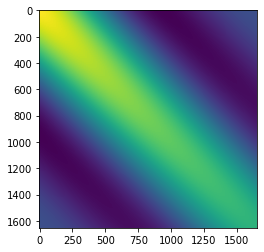

In [47]:
plt.imshow((eIeLO + eLOeI) )

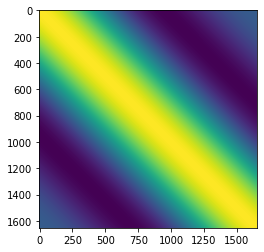

In [48]:
plt.imshow(D @(eIeLO + eLOeI) @ D)

In [49]:
print(np.diag(D @ eHIeHI @ D))

[1. 1. 1. ... 1. 1. 1.]


In [50]:
D = np.diag(chis_resample[window])
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, D @ IHi_kappa_windowed.T )
x = np.linalg.solve(L.T, y) 
res2 = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x )

In [51]:
D = np.diag(1/np.sqrt(np.diag(eHIeHI)))
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, D @ IHi_kappa_windowed.T )
x = np.linalg.solve(L.T, y) 
res3 = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


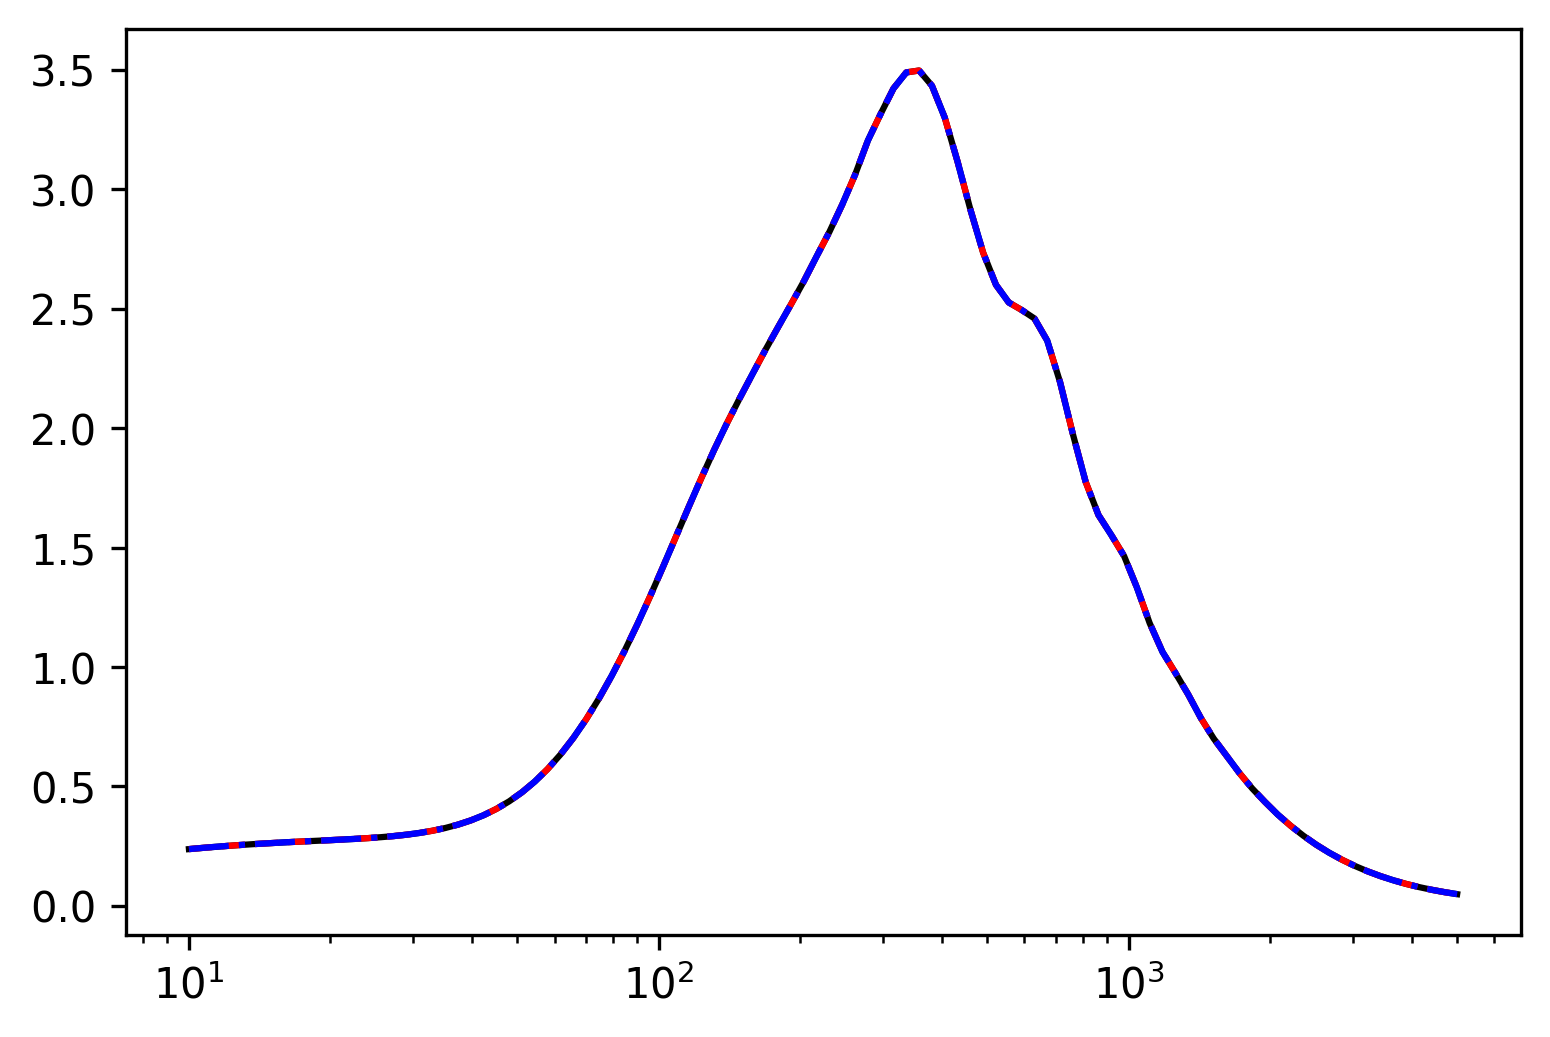

In [52]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res2, 'r--')
plt.plot(ells, ells**2 * res3, 'b-.')

plt.legend(frameon=False)
plt.xscale('log')